### Data Science Challenge
Task: Purpose of the assignment to build a model that can automatically categorize articles.

Delivered outputs: 
* Notebook with experimentation and initial model which performs better than random
* Scripts for cleaning the text data
* Scripts for training the model
* Scripts for evaluating algorithms
* Scripts to make predictions

Date Submitted: 31st Jan 2020

#### Installing libraries and reading data

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline 
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from yellowbrick.text import TSNEVisualizer

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.features.spacy_cleaner import spacy_cleaner
from src.models.algorithm_eval import algorithm_eval
from src.models.plot_confusion_matrix import plot_confusion_matrix



/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# read the dataset

sample_data = pd.read_csv(os.getcwd()+'/../data/raw/data_redacted.tsv', sep='\t')
sample_data['category_id'] = sample_data.category.factorize()[0] # add category id which will be useful later on


sample_data.head()

,title,text,url,category,category_id
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science,0
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life,1
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports,2
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science,0
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle,3


#### Text Data Cleaning

In [3]:
sample_data['cleaned_text'] = sample_data.text.apply(lambda x: spacy_cleaner(x))
# can takes some time to run

In [4]:
sample_data.head()

In [5]:
sample_data.to_pickle(os.getcwd()+'/../data/processed/sample_dat_1.pkl') # pickle processed data

#### Exploratory Data Analysis

In [6]:
sample_data = pd.read_pickle(os.getcwd()+'/../data/processed/sample_dat_1.pkl') 

In [7]:
# size of data 

sample_data.shape

(8646, 6)

In [8]:
# structure of dataset

sample_data.columns.to_series().groupby(sample_data.dtypes).groups

{dtype('int64'): Index(['category_id'], dtype='object'),
 dtype('O'): Index(['title', 'text', 'url', 'category', 'cleaned_text'], dtype='object')}

In [9]:
# missing data
sample_data.isnull().sum()

title           0
text            0
url             0
category        0
category_id     0
cleaned_text    0
dtype: int64

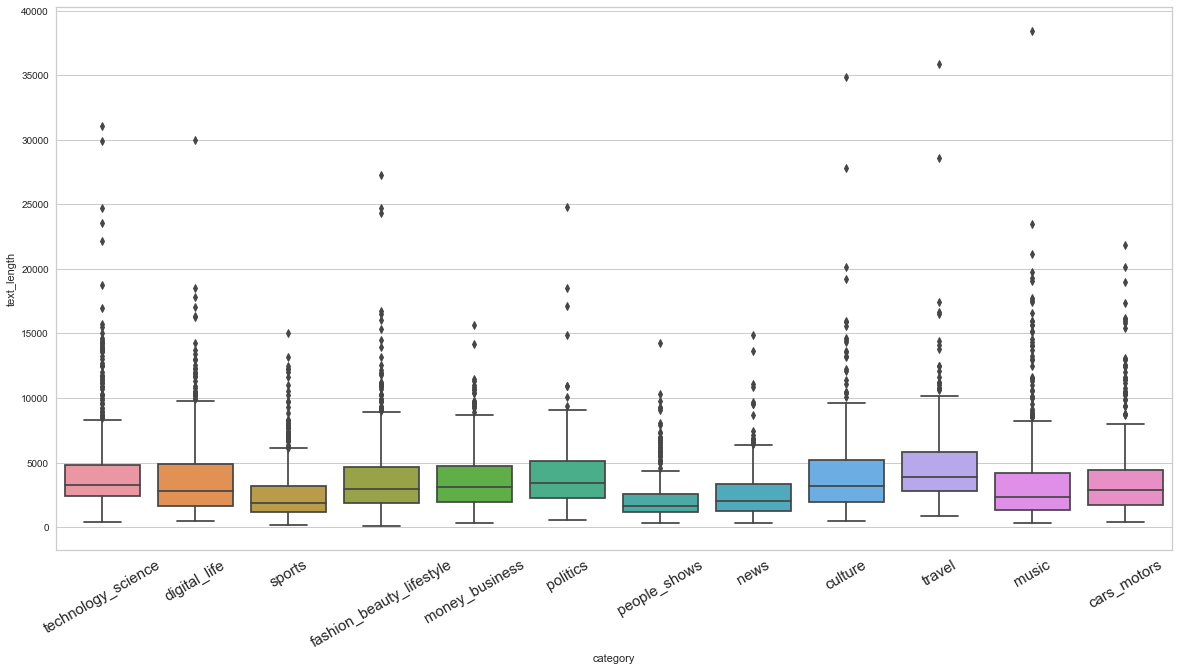

In [10]:
# potential variable of interest -- length of original text

fig = plt.figure(figsize = (20, 10))

sample_data['text_length'] = sample_data.text.apply(lambda x:len(x))

ax = sns.boxplot(y=sample_data['text_length'], x=sample_data['category'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, size=15);

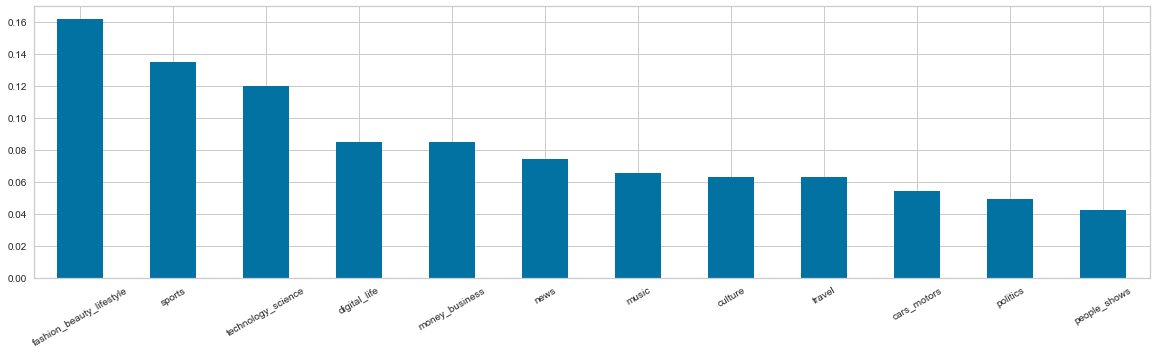

In [11]:
# class distribution -- some under represented categories

fig = plt.figure(figsize = (20, 5))

sample_data.category.value_counts(normalize=True).plot(kind='bar', rot=30);

In [12]:
# number of words generated

from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
cvec.fit(sample_data.cleaned_text)

print('-'*50)
print("number of words extracted from cleaned text:", len(cvec.get_feature_names()))
print('-'*50)

--------------------------------------------------
number of words extracted from cleaned text: 88789
--------------------------------------------------


In [13]:
definitions = sample_data.category.factorize()[1]
target_mapping = dict(zip(range(len(np.unique(sample_data['category_id']))), definitions))

target_mapping

{0: 'technology_science',
 1: 'digital_life',
 2: 'sports',
 3: 'fashion_beauty_lifestyle',
 4: 'money_business',
 5: 'politics',
 6: 'people_shows',
 7: 'news',
 8: 'culture',
 9: 'travel',
 10: 'music',
 11: 'cars_motors'}

In [14]:
# term frequency dataframe
cat_list = []

for i in target_mapping:
    cat_doc_matrix = cvec.transform(sample_data[sample_data.category_id==i].cleaned_text)
    cat_tf = np.sum(cat_doc_matrix, axis=0)
    cat = np.squeeze(np.asarray(cat_tf))
    cat_list.append(cat)
    
term_freq_df = pd.DataFrame(cat_list, columns=cvec.get_feature_names()).transpose()
term_freq_df = term_freq_df.rename(columns=dict(zip(target_mapping.keys(), target_mapping.values())))
term_freq_df['total'] = term_freq_df.sum(axis=1)

term_freq_df.sort_values(by=['total'], ascending=False).head(20)

,technology_science,digital_life,sports,fashion_beauty_lifestyle,money_business,politics,people_shows,news,culture,travel,music,cars_motors,total
say,2733,867,2165,2187,2106,1749,532,2063,915,489,668,560,17034
year,1722,676,2113,1529,1980,775,594,1010,964,826,1018,635,13842
time,1596,961,1547,2093,1063,328,304,458,774,896,794,478,11292
new,1670,1296,763,1309,1124,560,380,326,931,816,873,963,11011
like,1077,1272,815,2258,680,247,330,274,885,809,1405,535,10587
not,1061,1145,790,2063,971,247,283,361,795,734,714,559,9723
good,669,912,1037,1807,771,205,259,150,385,921,593,462,8171
people,1211,599,347,1504,961,612,159,887,659,451,596,179,8165
work,1185,779,421,1236,1090,339,176,366,1251,279,662,342,8126
come,667,719,1002,1118,584,343,205,331,556,511,608,417,7061


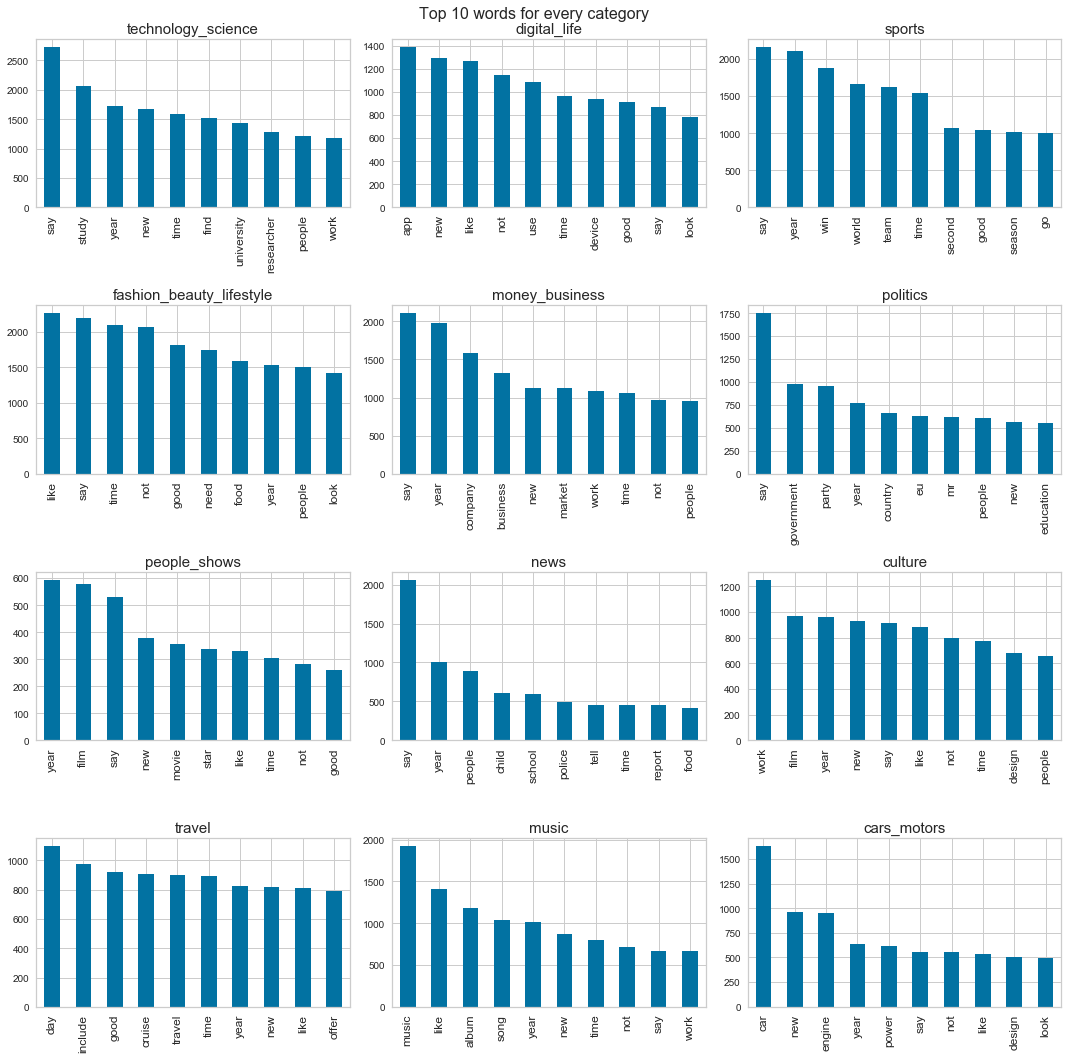

In [15]:
# top 10 tokens for every article category

fig = plt.figure(figsize = (15, 15))

j = 0

for i, v in target_mapping.items():
    top_10_tokens = term_freq_df.sort_values(by=v, ascending=False)[v].head(10)
    plt.subplot(4, 3, j+1)
    j += 1
    top_10_tokens.plot.bar()
    plt.title(v, fontsize=15)
    plt.xticks(fontsize=12, rotation=90)

fig.suptitle('Top 10 words for every category', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


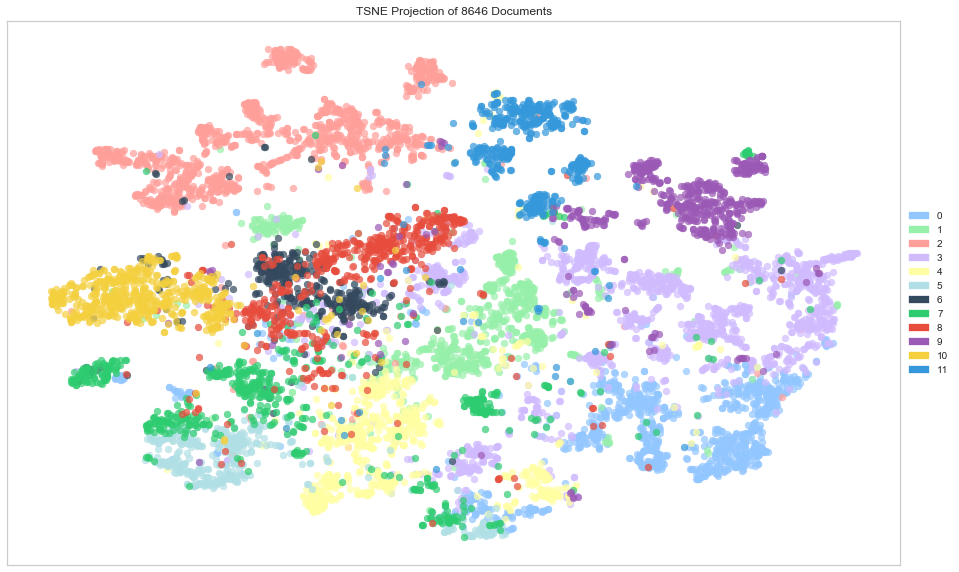

In [73]:
# Visualising articles similarity (t-SNE) 
# TF-IDF feature vector for each article, projected on 2 dimensions
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

color_list = np.array([(0.5725490196078431, 0.7764705882352941, 1.0),
 (0.592156862745098, 0.9411764705882353, 0.6666666666666666),
 (1.0, 0.6235294117647059, 0.6039215686274509),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.6901960784313725, 0.8784313725490196, 0.9019607843137255),
 (0.20392156862745098, 0.28627450980392155, 0.3686274509803922),
 (0.1803921568627451, 0.8, 0.44313725490196076),
 (0.9058823529411765, 0.2980392156862745, 0.23529411764705882),
 (0.6078431372549019, 0.34901960784313724, 0.7137254901960784),
 (0.9568627450980393, 0.8156862745098039, 0.24705882352941178),
 (0.20392156862745098, 0.596078431372549, 0.8588235294117647)
]) # parsing colors manually for every category


plt.figure(figsize = (20, 10))

# Load the data and create document vectors
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2')
# set sublinear_tf to true, to use the log of frequency, as word frequency follows an exponential distribution
# normalize the vectors so that length of a document does not bias its representation

X = tfidf.fit_transform(sample_data.cleaned_text)
y = sample_data.category_id


# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(colors=color_list)
tsne.fit(X, y)
tsne.show();

Remarks: 
* Differences in the size of the articles - with sports, people shows and news being shorter than travel and culture. 
* Say is a popular word across all categories, which shows some more text data cleaning is necessary. Nonetheless, there are stills signs of words unique to each category. University and reseach are some of the most frequently appearing words for technology science, car for car motors and music for music categories. 
* The t-SNE visualization of the articles, shows signs that some of the articles can be clearly segmented into the different categories based on their words.

#### Model Selection

In [17]:
# divide data into features and labels

features = tfidf.fit_transform(sample_data.cleaned_text)
target = sample_data.category_id

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.3,
                                                    stratify=target,
                                                    random_state=42)



# Oversampling method 2 
# using a class that performs over-sampling using SMOTE and an under-sampling algorithm that cleans the noisy samples
smote_enn = SMOTEENN(random_state=0) # Using edited nearest neighbours cleaning method - cleans more noisy data
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)


# Over sampling method 2
# using a class that only performs over-sampling using SMOTE
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


print("--"*55)
print("Training Data Size")
print(X_train.shape)
print('Training Data Target Distribution: %s' % Counter(y_train))
print('Test Data Target Distribution: %s' % Counter(y_test))
print('Resampled Data Target Distribution (SMOTE EEN): %s' % Counter(y_train_smote_enn))
print('Resampled Data Target Distribution (SMOTE): %s' % Counter(y_train_smote))
print("--"*55)


--------------------------------------------------------------------------------------------------------------
Training Data Size
(6052, 88789)
Training Data Target Distribution: Counter({3: 978, 2: 815, 0: 728, 1: 517, 4: 513, 7: 452, 10: 398, 8: 383, 9: 381, 11: 329, 5: 301, 6: 257})
Test Data Target Distribution: Counter({3: 420, 2: 350, 0: 312, 1: 221, 4: 220, 7: 194, 10: 170, 8: 164, 9: 163, 11: 141, 5: 129, 6: 110})
Resampled Data Target Distribution (SMOTE EEN): Counter({11: 955, 6: 953, 9: 950, 5: 948, 10: 934, 8: 904, 1: 859, 4: 833, 7: 830, 2: 698, 0: 665, 3: 24})
Resampled Data Target Distribution (SMOTE): Counter({10: 978, 5: 978, 2: 978, 9: 978, 4: 978, 7: 978, 1: 978, 3: 978, 0: 978, 11: 978, 6: 978, 8: 978})
--------------------------------------------------------------------------------------------------------------


In [18]:
# selection of algorithms to consider and measure performance
models = []
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100)))
models.append(('Gaussian NB', MultinomialNB()))


Model results using no sampling techniques
--------------------------------------------------
Logistic Regression Accuracy: 0.85658 (+/- 0.01144)
Logistic Regression F1-Score: 0.85548 (+/- 0.01208)
--------------------------------------------------
--------------------------------------------------
Random Forest Accuracy: 0.75396 (+/- 0.01102)
Random Forest F1-Score: 0.75524 (+/- 0.00877)
--------------------------------------------------


/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3

--------------------------------------------------
Gaussian NB Accuracy: 0.5309 (+/- 0.00448)
Gaussian NB F1-Score: 0.49258 (+/- 0.00483)
--------------------------------------------------


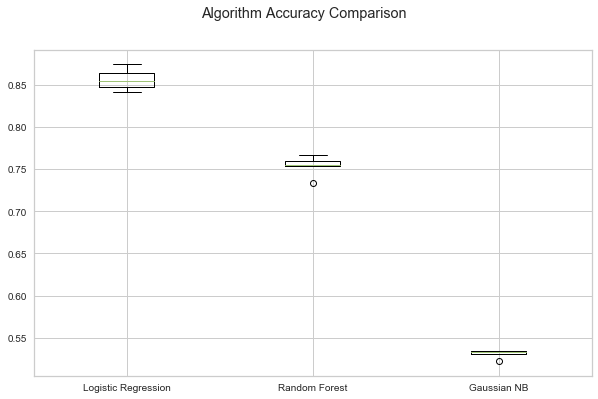

,Model Name,Accuracy Mean,Accuracy STD,F1 Mean,F1 STD,Precision Mean,Precision STD,Recall Mean,Recall STD
0,Logistic Regression,0.86,0.01,0.86,0.01,0.87,0.01,0.86,0.01
1,Random Forest,0.75,0.01,0.76,0.01,0.80,0.02,0.76,0.01
2,Gaussian NB,0.53,0.00,0.49,0.00,0.69,0.00,0.53,0.00


In [19]:
# scoring df for models with no sampling techniques
print("Model results using no sampling techniques")

scoring_results = algorithm_eval(models, X_train, y_train)
scoring_df = pd.DataFrame(scoring_results)

scoring_df

Model results using over sampling and under sampling techniques


/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3

--------------------------------------------------
Logistic Regression Accuracy: 0.98472 (+/- 0.00208)
Logistic Regression F1-Score: 0.98346 (+/- 0.00208)
--------------------------------------------------
--------------------------------------------------
Random Forest Accuracy: 0.97456 (+/- 0.00494)
Random Forest F1-Score: 0.97395 (+/- 0.00478)
--------------------------------------------------


/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shaq/anaconda3/envs/test/lib/python3

--------------------------------------------------
Gaussian NB Accuracy: 0.9307 (+/- 0.00473)
Gaussian NB F1-Score: 0.92817 (+/- 0.00524)
--------------------------------------------------


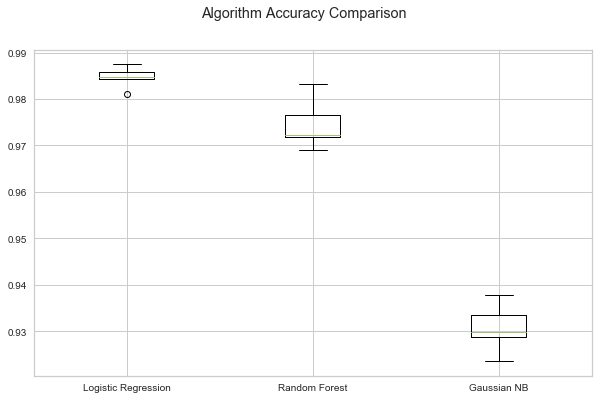

,Model Name,Accuracy Mean,Accuracy STD,F1 Mean,F1 STD,Precision Mean,Precision STD,Recall Mean,Recall STD
0,Logistic Regression,0.98,0.0,0.98,0.00,0.98,0.0,0.98,0.0
1,Random Forest,0.97,0.0,0.97,0.00,0.98,0.0,0.98,0.0
2,Gaussian NB,0.93,0.0,0.93,0.01,0.94,0.0,0.93,0.0


In [20]:
# scoring df for models with over sampling and under sampling techniques applied
print("Model results using over sampling and under sampling techniques")

scoring_results_smote_enn = algorithm_eval(models, X_train_smote_enn, y_train_smote_enn)
scoring_df_smote_enn = pd.DataFrame(scoring_results_smote_enn)

scoring_df_smote_enn

Model results using over sampling techniques
--------------------------------------------------
Logistic Regression Accuracy: 0.95297 (+/- 0.00131)
Logistic Regression F1-Score: 0.95279 (+/- 0.00135)
--------------------------------------------------
--------------------------------------------------
Random Forest Accuracy: 0.93115 (+/- 0.00566)
Random Forest F1-Score: 0.93138 (+/- 0.00422)
--------------------------------------------------
--------------------------------------------------
Gaussian NB Accuracy: 0.90755 (+/- 0.00581)
Gaussian NB F1-Score: 0.9061 (+/- 0.00599)
--------------------------------------------------


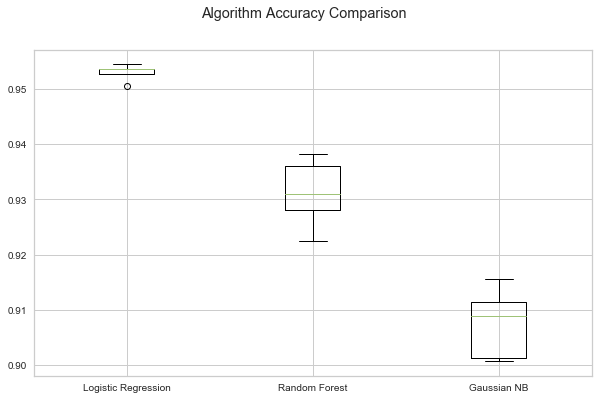

,Model Name,Accuracy Mean,Accuracy STD,F1 Mean,F1 STD,Precision Mean,Precision STD,Recall Mean,Recall STD
0,Logistic Regression,0.95,0.00,0.95,0.00,0.95,0.00,0.95,0.00
1,Random Forest,0.93,0.01,0.93,0.00,0.93,0.00,0.93,0.00
2,Gaussian NB,0.91,0.01,0.91,0.01,0.91,0.01,0.91,0.01


In [21]:
# scoring df for models with over sampling techniques applies
print("Model results using over sampling techniques")

scoring_results_smote = algorithm_eval(models, X_train_smote, y_train_smote)
scoring_df_smote = pd.DataFrame(scoring_results_smote)

scoring_df_smote

For the next steps of the task and to keep things simple, I decided to select the Logistic Regression model with no sampling techniques applied. It performs reasonably well (above random), with an average accuracy and f1-score of 0.85, but most importantly it is able to predict all classes and shows small amounts of variance in results across all five cross-validations (as shown in the boxplots). 

#### Selected Model Evaluation 


In [22]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)


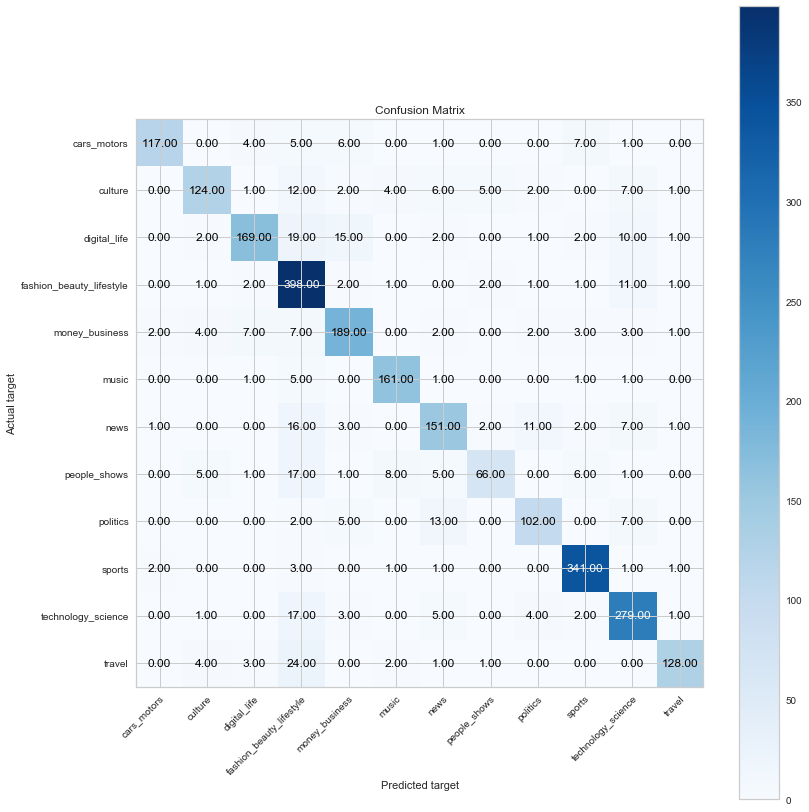

In [23]:
plot_confusion_matrix(target_mapping, y_test, y_pred)

In [24]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

score = {'Accuracy (Test Data)': round(model.score(X_test, y_test), 2),
         'Accuracy (Train Data)': round(cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean(), 2),
         'F1-Score (Test Data)': round(f1_score(y_test, y_pred, average='weighted'), 2),
         'F1-Score (Train Data)': round(cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted').mean(), 2),
         'Precision (Test Data)': round(precision_score(y_test, y_pred, average='weighted'), 2),
         'Precision (Train Data)': round(cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision_weighted').mean(), 2),
         'Recall (Test Data)': round(recall_score(y_test, y_pred, average='weighted'), 2),
         'Recall (Train Data)': round(cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted').mean(), 2)}
    
score # single iteration results can be misleading, so evaluating based on cross validated results

{'Accuracy (Test Data)': 0.86,
 'Accuracy (Train Data)': 0.86,
 'F1-Score (Test Data)': 0.86,
 'F1-Score (Train Data)': 0.86,
 'Precision (Test Data)': 0.86,
 'Precision (Train Data)': 0.87,
 'Recall (Test Data)': 0.86,
 'Recall (Train Data)': 0.86}